In [1]:
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings

filterwarnings('ignore')

## Load Data and Select Important Columns

In [4]:
electronics_data = []
with open("Electronics_5.json", "r") as file:
    for line in file:
        electronics_data.append(json.loads(line))

electronics_df = pd.DataFrame(electronics_data)

In [5]:
movies_data = []
with open("Movies_and_TV_5.json", "r") as file:
    for line in file:
        movies_data.append(json.loads(line))
        
movies_df = pd.DataFrame(movies_data)

In [6]:
electronics = electronics_df[['reviewText', 'overall']]
movies = movies_df[['reviewText', 'overall']]

In [7]:
electronics

,reviewText,overall
0,This is the best novel I have read in 2 or 3 y...,5.0
1,"Pages and pages of introspection, in the style...",3.0
2,This is the kind of novel to read when you hav...,5.0
3,What gorgeous language! What an incredible wri...,5.0
4,I was taken in by reviews that compared this b...,3.0
...,...,...
6739585,"These seem like quality USB cables, time will ...",4.0
6739586,"Works great, love the longer cord. As with any...",4.0
6739587,"Ok here is an odd thing that happened to me, I...",5.0
6739588,Works well.,5.0


In [8]:
movies

,reviewText,overall
0,So sorry I didn't purchase this years ago when...,5.0
1,Believe me when I tell you that you will recei...,5.0
2,"I have seen X live many times, both in the ear...",5.0
3,"I was so excited for this! Finally, a live co...",5.0
4,X is one of the best punk bands ever. I don't ...,5.0
...,...,...
3410014,The singing parts are very good as expected fr...,4.0
3410015,This recording of the 2015 production by the M...,5.0
3410016,I do not wish to write a review about this rel...,4.0
3410017,It was a gift.,5.0


## Data Cleaning

#### Check for Missing Values

In [9]:
electronics.isna().sum()

reviewText    1353
overall          0
dtype: int64

In [10]:
movies.isna().sum()

reviewText    1581
overall          0
dtype: int64

In [11]:
electronics.dropna(inplace=True)
electronics.isna().sum()

reviewText    0
overall       0
dtype: int64

In [12]:
movies.dropna(inplace=True)
movies.isna().sum()

reviewText    0
overall       0
dtype: int64

#### Check for Duplicates

In [13]:
electronics.duplicated().sum()

1108746

In [14]:
movies.duplicated().sum()

743491

In [15]:
electronics.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)

In [16]:
electronics.shape

(5629491, 2)

In [17]:
movies.shape

(2664947, 2)

#### Remove rows with short reviews (less than 5 characters)

In [18]:
electronics[electronics['reviewText'].str.len() < 5].shape

(2035, 2)

In [19]:
movies[movies['reviewText'].str.len() < 5].shape

(2228, 2)

In [20]:
# only retain rows with more than 5 characters
electronics = electronics[electronics['reviewText'].str.len() > 5]
movies = movies[movies['reviewText'].str.len() > 5]

In [21]:
electronics.shape

(5625973, 2)

In [22]:
movies.shape

(2661230, 2)

## Pre-processing

#### Convert ratings to sentiment labels

- 1 - 2 stars: negative sentiment (label 0)
- 3 stars: neutral sentiment (label 1)
- 4 - 5 stars: positive sentiment (label 2)

In [23]:
electronics['sentiment'] = electronics['overall'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
movies['sentiment'] = movies['overall'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

In [24]:
electronics.drop(columns='overall', inplace=True)
movies.drop(columns='overall', inplace=True)

In [25]:
electronics

,reviewText,sentiment
0,This is the best novel I have read in 2 or 3 y...,2
1,"Pages and pages of introspection, in the style...",1
2,This is the kind of novel to read when you hav...,2
3,What gorgeous language! What an incredible wri...,2
4,I was taken in by reviews that compared this b...,1
...,...,...
6739584,not holding up over time :(,1
6739585,"These seem like quality USB cables, time will ...",2
6739586,"Works great, love the longer cord. As with any...",2
6739587,"Ok here is an odd thing that happened to me, I...",2


In [26]:
movies

,reviewText,sentiment
0,So sorry I didn't purchase this years ago when...,2
1,Believe me when I tell you that you will recei...,2
2,"I have seen X live many times, both in the ear...",2
3,"I was so excited for this! Finally, a live co...",2
4,X is one of the best punk bands ever. I don't ...,2
...,...,...
3410012,No problem whatsoever,2
3410013,"This is a very, very good production of Verdi'...",2
3410014,The singing parts are very good as expected fr...,2
3410015,This recording of the 2015 production by the M...,2


#### Check for Class Imbalance

In [27]:
x = electronics['sentiment'].value_counts().index.to_list()
y = electronics['sentiment'].value_counts().to_numpy()

Text(10.38827160493827, 0.5, '%')

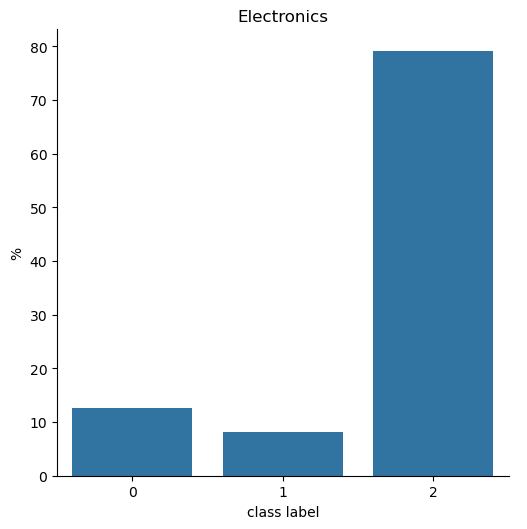

In [28]:
y = y / sum(y) * 100 # convert counts to percentages

sns.catplot(x=x, y=y, kind='bar')
plt.title('Electronics')
plt.xlabel('class label')
plt.ylabel('%')

In [29]:
x = movies['sentiment'].value_counts().index.to_list()
y = movies['sentiment'].value_counts().to_numpy()

Text(10.38827160493827, 0.5, '%')

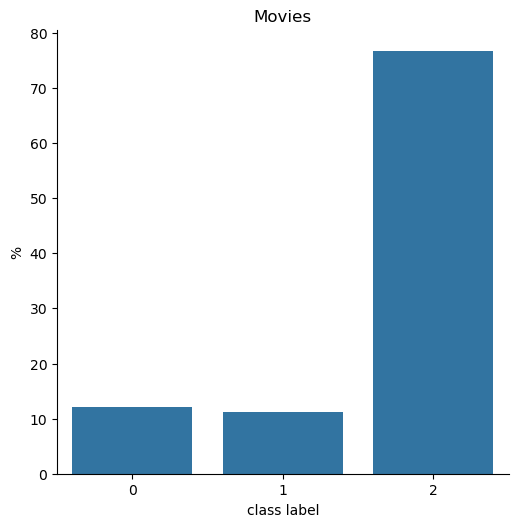

In [30]:
y = y / sum(y) * 100 # convert counts to percentages

sns.catplot(x=x, y=y, kind='bar')
plt.title('Movies')
plt.xlabel('class label')
plt.ylabel('%')

***In both datasets, the positive class is overrepresented compared to the other classes.***

## Data Splitting

The Electronics Dataset is the source domain. 
We'll split into 80% for training and 20% for validation.

The movies dataset will be reserved for evaluating cross-domain performance (testing).

- Training Set: Used for model learning.
- Validation Set: Ensures the model generalizes well during training.
- Test Set: Evaluates performance on unseen, cross-domain data (Movies).

In [31]:
from sklearn.model_selection import train_test_split

train_electronics, val_electronics = train_test_split(
    electronics, test_size=0.2, stratify=electronics['sentiment'], random_state=42
)

test_movies = movies

In [32]:
print("Training set size:", len(train_electronics))
print("Validation set size:", len(val_electronics))
print("Test set size:", len(test_movies))

Training set size: 4500778
Validation set size: 1125195
Test set size: 2661230


In [2]:
# Save datasets to CSV files for easy use later.
# train_electronics.to_csv('train_electronics.csv', index=False)
# val_electronics.to_csv('val_electronics.csv', index=False)
# test_movies.to_csv('test_movies.csv', index=False)